# VEME NGS Module: NS-Forest

This notebook demonstrates an example of running NS-Forest algorithm developed by Aevermann et al. to identify the minimum marker gene combininations that define a cell type.  We will apply this to the COVID-19 lung scRNA-seq response dataset to identify the markers genes for the provided cell types.  The pulication for NS-Forest can be found at https://genome.cshlp.org/content/31/10/1767

### Install the propper version of numpy.  v1.21.0 is required for using the anndata library

In [1]:
%pip uninstall numpy -y
%pip install numpy==1.21.0

Found existing installation: numpy 1.21.0
Uninstalling numpy-1.21.0:
  Successfully uninstalled numpy-1.21.0
Note: you may need to restart the kernel to use updated packages.
  Using cached numpy-1.21.0-cp38-cp38-macosx_10_9_x86_64.whl (16.9 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-network 0.31.0 requires numpy>=1.22.4, but you have numpy 1.21.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


### ----- MUST RESTART THE KERNEL BEFORE RUNNING -----

In [1]:
import numpy as np
import pandas as pd
import anndata as ad
import nsforest as ns
import scanpy as sc
import warnings
import pickle
warnings.filterwarnings("ignore")

## 1.) Load in the processed cell by gene counts matrix

In [2]:
counts = pd.read_csv("GSE171524_processed_data.csv.gz", compression = "gzip")
counts = counts.set_index(counts.columns[0])
counts = counts.drop(columns = counts.columns[0])
counts = counts.transpose()
counts.shape

(116313, 2000)

## 2.) Convert the cell by gene matrix to anndata data structure

In [19]:
adata = ad.AnnData(counts)
adata.obs_names = list(counts.index)
adata.var_names = list(counts.columns)
adata

AnnData object with n_obs × n_vars = 116313 × 2000

In [20]:
metadata = pd.read_csv("GSE171524_lung_metaData.txt", sep = "\t")
cell_types = list(metadata["cell_type_intermediate"])
adata.obs["cell_type"] = cell_types
adata.obs

,cell_type
ATTCACTGTAACAGGC-1_1,Airway epithelial cells
TAACTTCCAACCACGC-1_1,Macrophages
TTGGGTACACGACAAG-1_1,Airway epithelial cells
AGGCCACAGAGTCACG-1_1,Airway epithelial cells
CACTGAAGTCGAAGCA-1_1,Airway epithelial cells
...,...
CCTAAGAAGTTGTCAC-1_27,Fibroblasts
CGTGAATCATGTCTAG-1_27,Macrophages
GCCGATGAGTAAACGT-1_27,AT2
AGGGTGAGTATCAGGG-1_27,AT1


In [6]:
adata

AnnData object with n_obs × n_vars = 116313 × 2000
    obs: 'cell_type'

## 3.) Run NS-Forest with the intermediate cell types

For an explanation on the NS-forest hyperparameters, see https://jcventerinstitute.github.io/celligrate/tutorials/NS-Forest_tutorial.html

### WARNING! This takes a long time to run! Just observe results, do not run it

In [21]:
# This take a long time, so it's a good idea to save the result to a pickle, a binarized storag file

NSForest_results = ns.NSForest(adata, cluster_header='cell_type', n_trees=100, n_genes_eval=6)
with open('ns_forest_100_trees.pkl', 'wb') as handle:
    pickle.dump(NSForest_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

Preparing data...
--- 0.021200895309448242 seconds ---
Calculating medians...
--- 16.365719079971313 seconds ---
Number of clusters to evaluate: 19
1 out of 19:
	AT1
	['RGS6', 'XKR4']
	0.8635185797772632
2 out of 19:
	AT2
	['SDR16C5', 'SFTPA1']
	0.8251503553854566
3 out of 19:
	Airway epithelial cells
	['AC019211.1', 'DCDC1']
	0.7385469917420371
4 out of 19:
	B cells
	['FAM30A', 'AC008691.1']
	0.6981929124618634
5 out of 19:
	CD4+ T cells
	['GREM2', 'IL7R']
	0.7397155267864748
6 out of 19:
	CD8+ T cells
	Only 7 out of 15 top Random Forest features with median > 0 will be further evaluated.
	['CCL3', 'DTHD1', 'IFNG-AS1']
	0.611177842153607
7 out of 19:
	Cycling NK/T cells
	['IGHG1', 'LINC02099', 'GALNT14']
	0.7763899093803576
8 out of 19:
	Dendritic cells
	['MS4A1', 'CYYR1', 'HLA-DPA1']
	0.7467625899280577
9 out of 19:
	Endothelial cells
	['RAMP3', 'FENDRR']
	0.873921514055107
10 out of 19:
	Fibroblasts
	['PTGDS', 'SVEP1']
	0.9174016504388071
11 out of 19:
	Macrophages
	['ATP6V0D2']
	0.

### Run this instead, a saved version of the results ...

In [22]:
with open('ns_forest_100_trees.pkl', 'rb') as handle:
    NSForest_results = pickle.load(handle)

In [23]:
NSForest_results

,clusterName,clusterSize,f_score,PPV,TN,FP,FN,TP,marker_count,NSForest_markers,binary_genes
0,AT1,9608,0.863519,0.939703,106303,402,3343,6265,2,"[RGS6, XKR4]","[CTSE, AC005165.1, ANKRD29, RGS6, XKR4, AC0223..."
1,AT2,11341,0.825150,0.877850,103922,1050,3795,7546,2,"[SDR16C5, SFTPA1]","[LAMP3, SDR16C5, SFTPA1, C3orf79, DPP10, SFTPA..."
2,Airway epithelial cells,7332,0.738547,0.923763,108733,248,4327,3005,2,"[AC019211.1, DCDC1]","[ARMC3, LMNTD1, AC019211.1, DCDC1, TMPRSS4, BP..."
3,B cells,1845,0.698193,0.985099,114459,9,1250,595,2,"[FAM30A, AC008691.1]","[FAM30A, AC008691.1, AP001636.3, AC025887.2, A..."
4,CD4+ T cells,7586,0.739716,0.874182,108227,500,4112,3474,2,"[GREM2, IL7R]","[GREM2, LEF1, ST8SIA1, LINC02694, IL7R, NELL2,..."
5,CD8+ T cells,3561,0.611178,0.653323,111834,918,1831,1730,3,"[CCL3, DTHD1, IFNG-AS1]","[CCL3, AC104078.2, DTHD1, AC243829.2, IFNG-AS1..."
6,Cycling NK/T cells,2814,0.776390,0.947683,113429,70,1546,1268,3,"[IGHG1, LINC02099, GALNT14]","[IGHG1, LINC02099, AC005599.1, BUB1B, KCNQ5, G..."
7,Dendritic cells,1083,0.746763,0.867893,115151,79,564,519,3,"[MS4A1, CYYR1, HLA-DPA1]","[AC099560.1, IDO1, MS4A1, CYYR1, AC116362.1, H..."
8,Endothelial cells,5386,0.873922,0.931981,110652,275,1618,3768,2,"[RAMP3, FENDRR]","[MCAM, EPAS1, RAMP3, CAVIN2, HMCN2, FENDRR, NO..."
9,Fibroblasts,21472,0.917402,0.958597,94115,726,4663,16809,2,"[PTGDS, SVEP1]","[PTGDS, C7, GFPT2, COL6A6, NFASC, SVEP1, ITGBL..."


## 4.) Visualize the Results

### a. Marker Results

1.) Visualize markers with stacked violin plot

         Falling back to preprocessing with `sc.pp.pca` and default params.


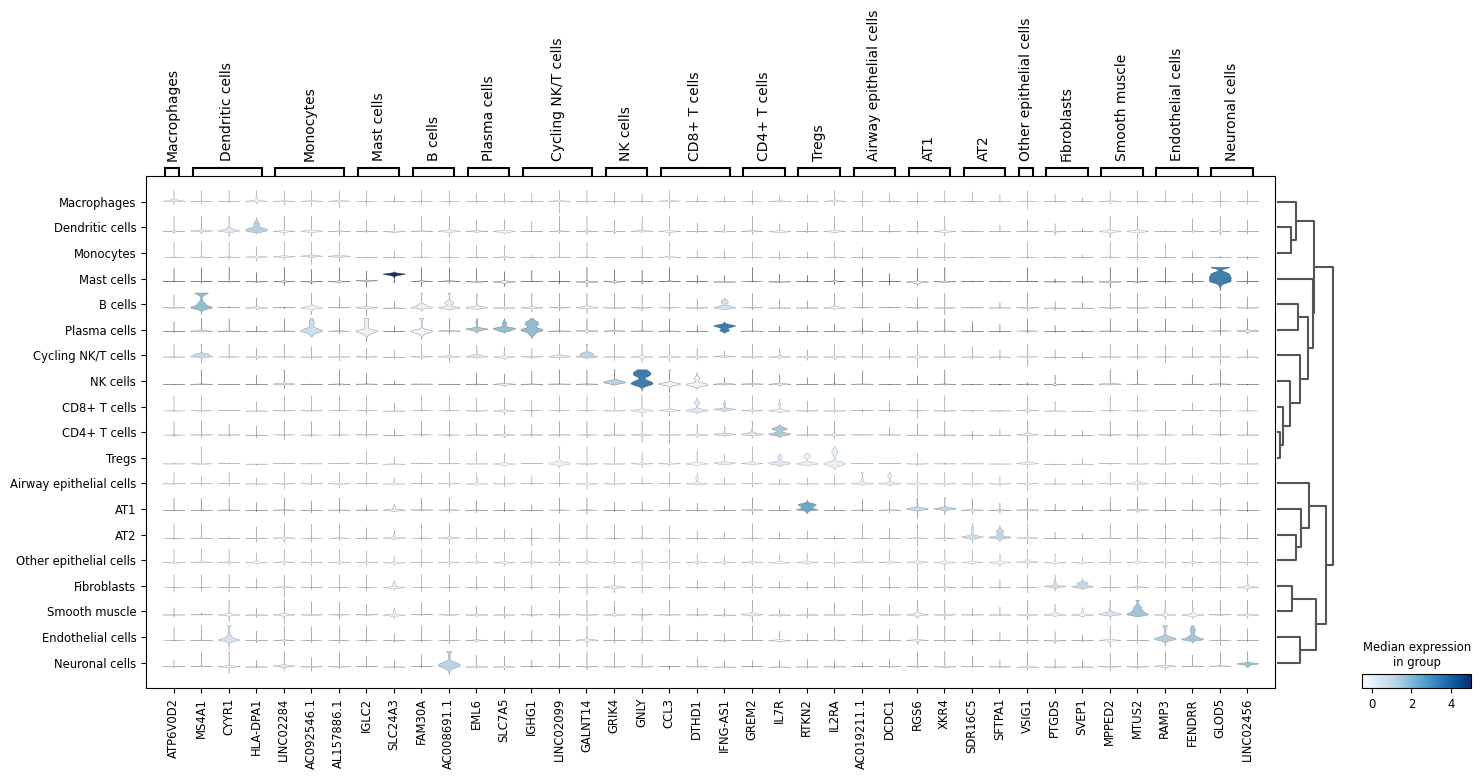

In [24]:
markers = dict(zip(NSForest_results['clusterName'], NSForest_results['NSForest_markers']))
sc.pl.stacked_violin(adata, markers, groupby='cell_type', dendrogram=True)

2.) Visualize markers with a matrix heatmap

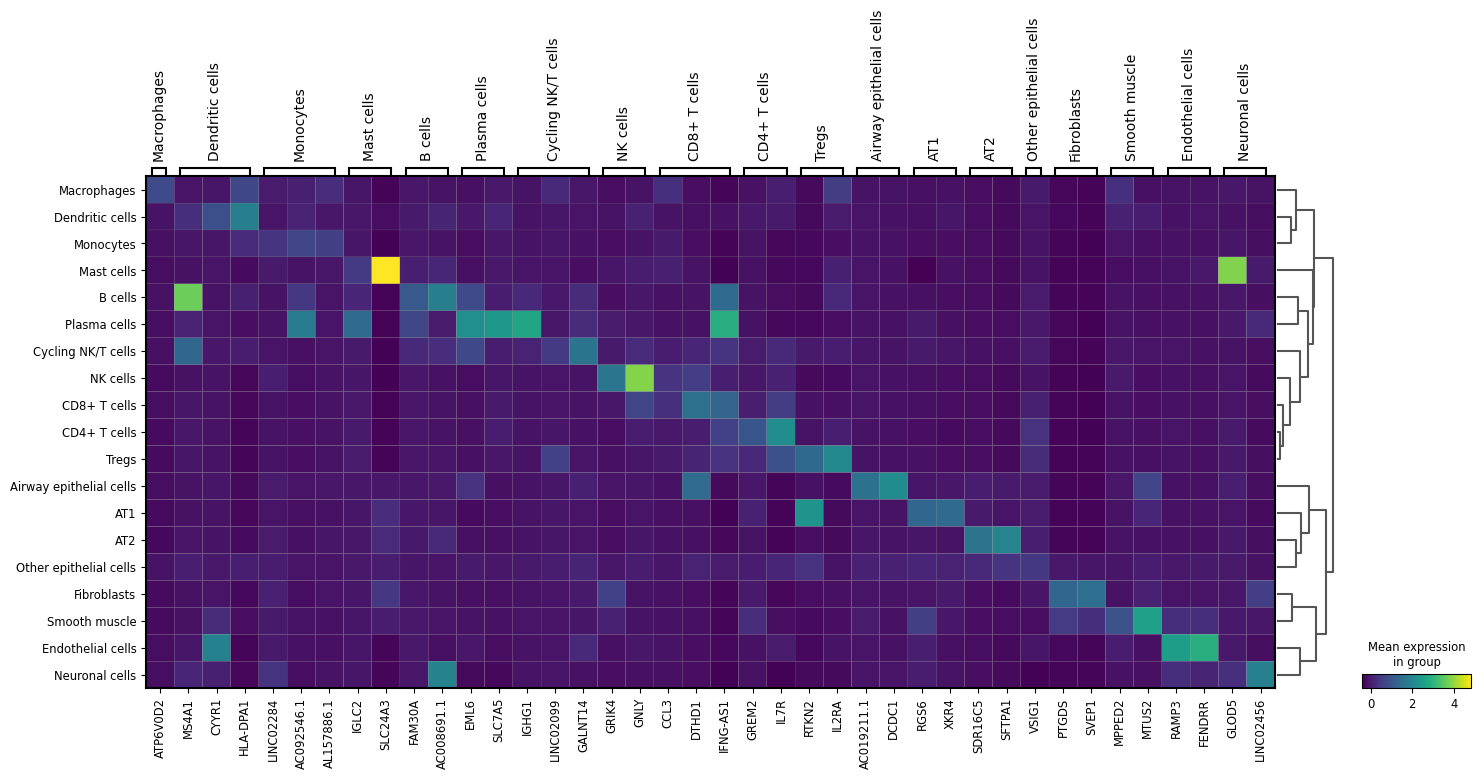

In [25]:
sc.pl.matrixplot(adata, markers, groupby='cell_type', dendrogram = True)

3.) Visualize markers with tracksplot

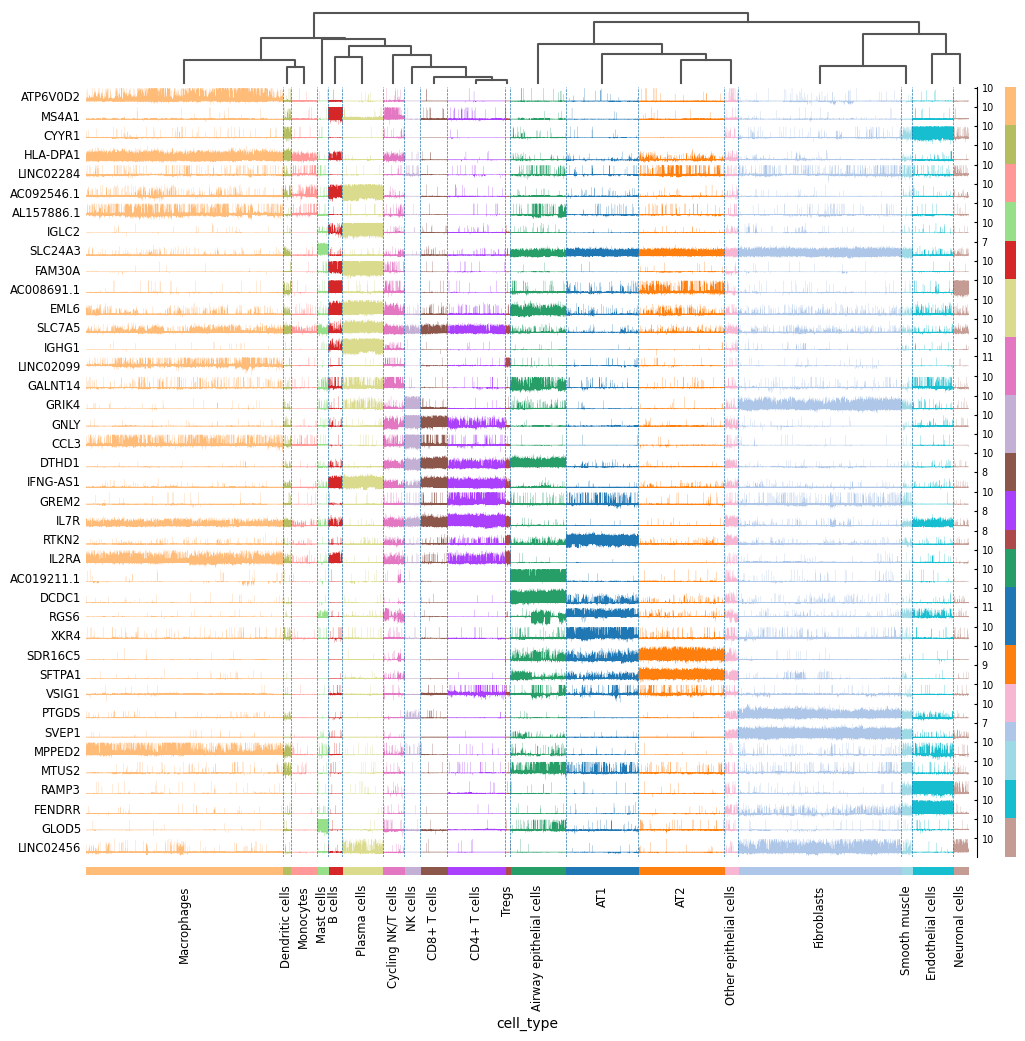

In [26]:
sc.pl.tracksplot(adata, markers, groupby='cell_type', dendrogram = True)

### b. Binary Gene Results

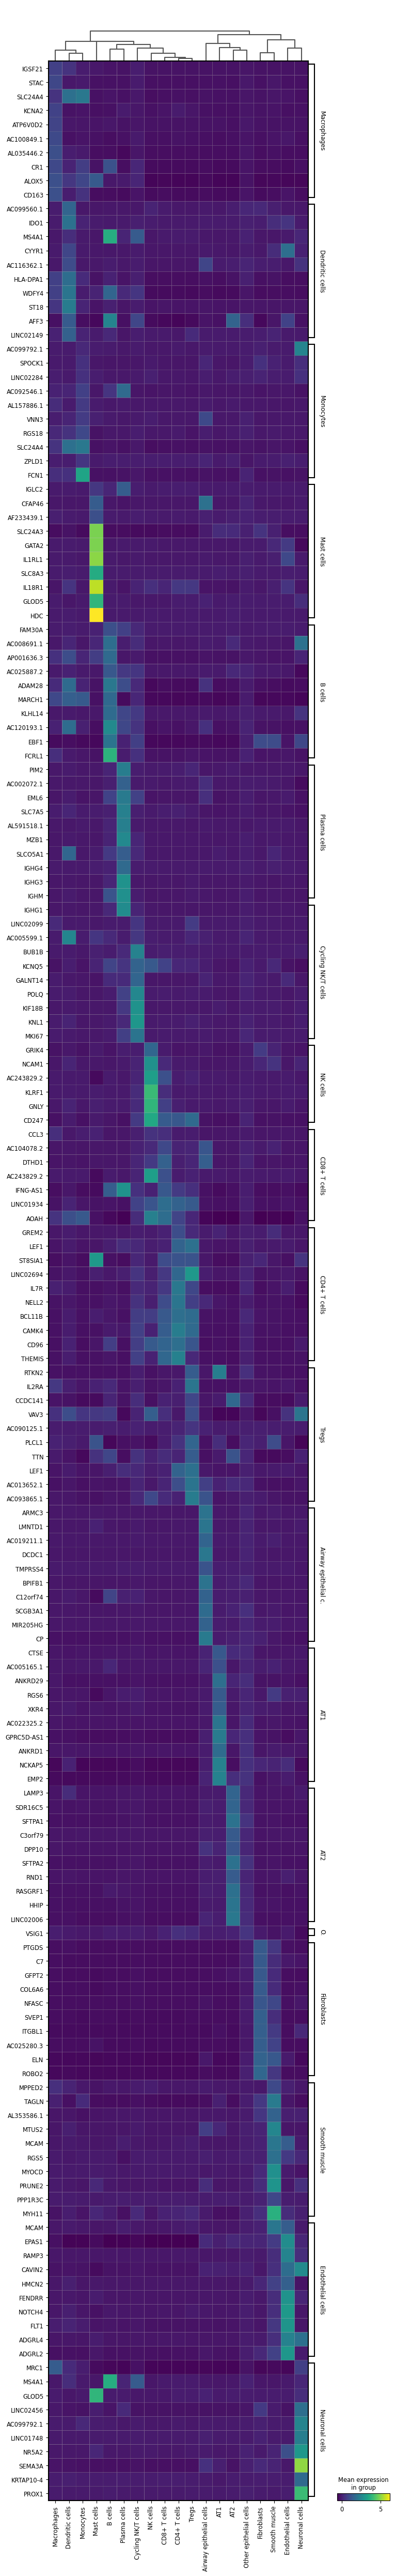

In [27]:
binary_genes = dict(zip(NSForest_results['clusterName'], NSForest_results['binary_genes']))
sc.pl.matrixplot(adata, binary_genes, groupby='cell_type', dendrogram=True, swap_axes=True)

## 5.) Exercise: Run NS-Forest with the main cell types

In [15]:
# Run this to annotate main cell type in the anndata structure

cell_type_main = list(metadata["cell_type_main"])
adata.obs["cell_type_main"] = cell_type_main
adata.obs

,cell_type,cell_type_main
ATTCACTGTAACAGGC-1_1,Airway epithelial cells,Epithelial cells
TAACTTCCAACCACGC-1_1,Macrophages,Myeloid
TTGGGTACACGACAAG-1_1,Airway epithelial cells,Epithelial cells
AGGCCACAGAGTCACG-1_1,Airway epithelial cells,Epithelial cells
CACTGAAGTCGAAGCA-1_1,Airway epithelial cells,Epithelial cells
...,...,...
CCTAAGAAGTTGTCAC-1_27,Fibroblasts,Fibroblasts
CGTGAATCATGTCTAG-1_27,Macrophages,Myeloid
GCCGATGAGTAAACGT-1_27,AT2,Epithelial cells
AGGGTGAGTATCAGGG-1_27,AT1,Epithelial cells


In [28]:
# Code to run NS-forest here

# Choose parameters from https://jcventerinstitute.github.io/celligrate/tutorials/NS-Forest_tutorial.html wisely:

# Recommended: Save the results to a pickle





In [30]:
# Code to visualize NS-forest results here:

# Go to https://scanpy-tutorials.readthedocs.io/en/latest/plotting/core.html to learn about plotting options in scanpy






## EXTRA: Analyze Marker Genes of the more Fine Cell Types

In [15]:
cell_type_fine = list(metadata["cell_type_fine"])
adata.obs["cell_type_fine"] = cell_type_fine
adata.obs

,cell_type,cell_type_fine
ATTCACTGTAACAGGC-1_1,Airway epithelial cells,Airway ciliated
TAACTTCCAACCACGC-1_1,Macrophages,Alveolar macrophages
TTGGGTACACGACAAG-1_1,Airway epithelial cells,Airway ciliated
AGGCCACAGAGTCACG-1_1,Airway epithelial cells,Airway ciliated
CACTGAAGTCGAAGCA-1_1,Airway epithelial cells,Airway ciliated
...,...,...
CCTAAGAAGTTGTCAC-1_27,Fibroblasts,Intermediate pathological FB
CGTGAATCATGTCTAG-1_27,Macrophages,Transitioning MDM
GCCGATGAGTAAACGT-1_27,AT2,AT2
AGGGTGAGTATCAGGG-1_27,AT1,AT1


### WARNING! This takes a long time to run! Just observe results, do not run it

In [16]:
NSForest_results_2 = ns.NSForest(adata, cluster_header='cell_type_fine', n_trees=100, n_genes_eval=6)
with open('ns_forest_results_07-14.pkl', 'wb') as handle:
    pickle.dump(NSForest_results_2, handle, protocol=pickle.HIGHEST_PROTOCOL)

Preparing data...
--- 0.03661203384399414 seconds ---
Calculating medians...
--- 15.025766849517822 seconds ---
Number of clusters to evaluate: 41
1 out of 41:
	AT1
	['XKR4', 'ANKRD1']
	0.8665873367279168
2 out of 41:
	AT2
	['SDR16C5', 'RASGRF1']
	0.8348666563213549
3 out of 41:
	Activated B cells
	['NYAP2', 'ENKUR', 'AC025887.2']
	0.7973291437549097
4 out of 41:
	Adventitial FB
	['LINC01748', 'ERBB4', 'H19']
	0.8919376454821188
5 out of 41:
	Airway basal
	['P2RY14', 'NRG1', 'RASSF6']
	0.8213859020310634
6 out of 41:
	Airway ciliated
	['AGBL4', 'CFAP43']
	0.9057586060348491
7 out of 41:
	Airway club
	['MIR4300HG', 'BBOX1-AS1', 'TLL1', 'SFTPB', 'TMEM45A']
	0.7263948497854077
8 out of 41:
	Airway goblet
	['SLC5A8', 'DHRS9', 'CXCL8']
	0.7901809711521234
9 out of 41:
	Airway mucous
	Only 4 out of 15 top Random Forest features with median > 0 will be further evaluated.
	['ARMC3']
	0.171448857703713
10 out of 41:
	Airway smooth muscle
	['MPPED2', 'SLC30A8', 'PRUNE2']
	0.8470847084708472
11 o

In [13]:
with open('ns_forest_results_07-14.pkl', 'rb') as handle:
    NSForest_results_2 = pickle.load(handle)

In [14]:
NSForest_results_2

,clusterName,clusterSize,f_score,PPV,TN,FP,FN,TP,marker_count,NSForest_markers,binary_genes
0,AT1,9608,0.866587,0.944361,106336,369,3345,6263,2,"[XKR4, ANKRD1]","[CTSE, AC005165.1, ANKRD29, AC022325.2, XKR4, ..."
1,AT2,11341,0.834867,0.892206,104062,910,3809,7532,2,"[SDR16C5, RASGRF1]","[LAMP3, SDR16C5, SFTPA1, C3orf79, SFTPA2, RASG..."
2,Activated B cells,1299,0.797329,0.966667,114993,21,690,609,3,"[NYAP2, ENKUR, AC025887.2]","[IGHM, NYAP2, CR1, ENKUR, FAM30A, AC025887.2, ..."
3,Adventitial FB,3773,0.891938,0.972318,112468,72,1244,2529,3,"[LINC01748, ERBB4, H19]","[AC097662.1, LINC01748, ERBB4, AOX1, H19, SCAR..."
4,Airway basal,534,0.821386,0.964912,115769,10,259,275,3,"[P2RY14, NRG1, RASSF6]","[P2RY14, ENPP1, EDNRA, NRG1, PTPRQ, RASSF6, CX..."
5,Airway ciliated,2392,0.905759,0.971510,113871,50,687,1705,2,"[AGBL4, CFAP43]","[AGBL4, CDHR4, RP1, TMEM232, CFAP43, PACRG, EC..."
6,Airway club,1232,0.726395,0.789965,114901,180,555,677,5,"[MIR4300HG, BBOX1-AS1, TLL1, SFTPB, TMEM45A]","[MIR4300HG, BBOX1-AS1, TLL1, SFTPB, TMEM45A, K..."
7,Airway goblet,1757,0.790181,0.922594,114482,74,875,882,3,"[SLC5A8, DHRS9, CXCL8]","[SLC5A8, DHRS9, CTNNA3, MIR31HG, CXCL8, AC0109..."
8,Airway mucous,1307,0.171449,0.145079,110168,4838,486,821,1,[ARMC3],"[MLPH, SAMD12, RGS6, ARMC3]"
9,Airway smooth muscle,1020,0.847085,0.941896,115255,38,404,616,3,"[MPPED2, SLC30A8, PRUNE2]","[MPPED2, ANK1, SLC30A8, PPP1R3C, PRUNE2, MTUS2..."


categories: AT1, AT2, Airway epithelial cells, etc.
var_group_labels: AT1, AT2, Activated B cells, etc.


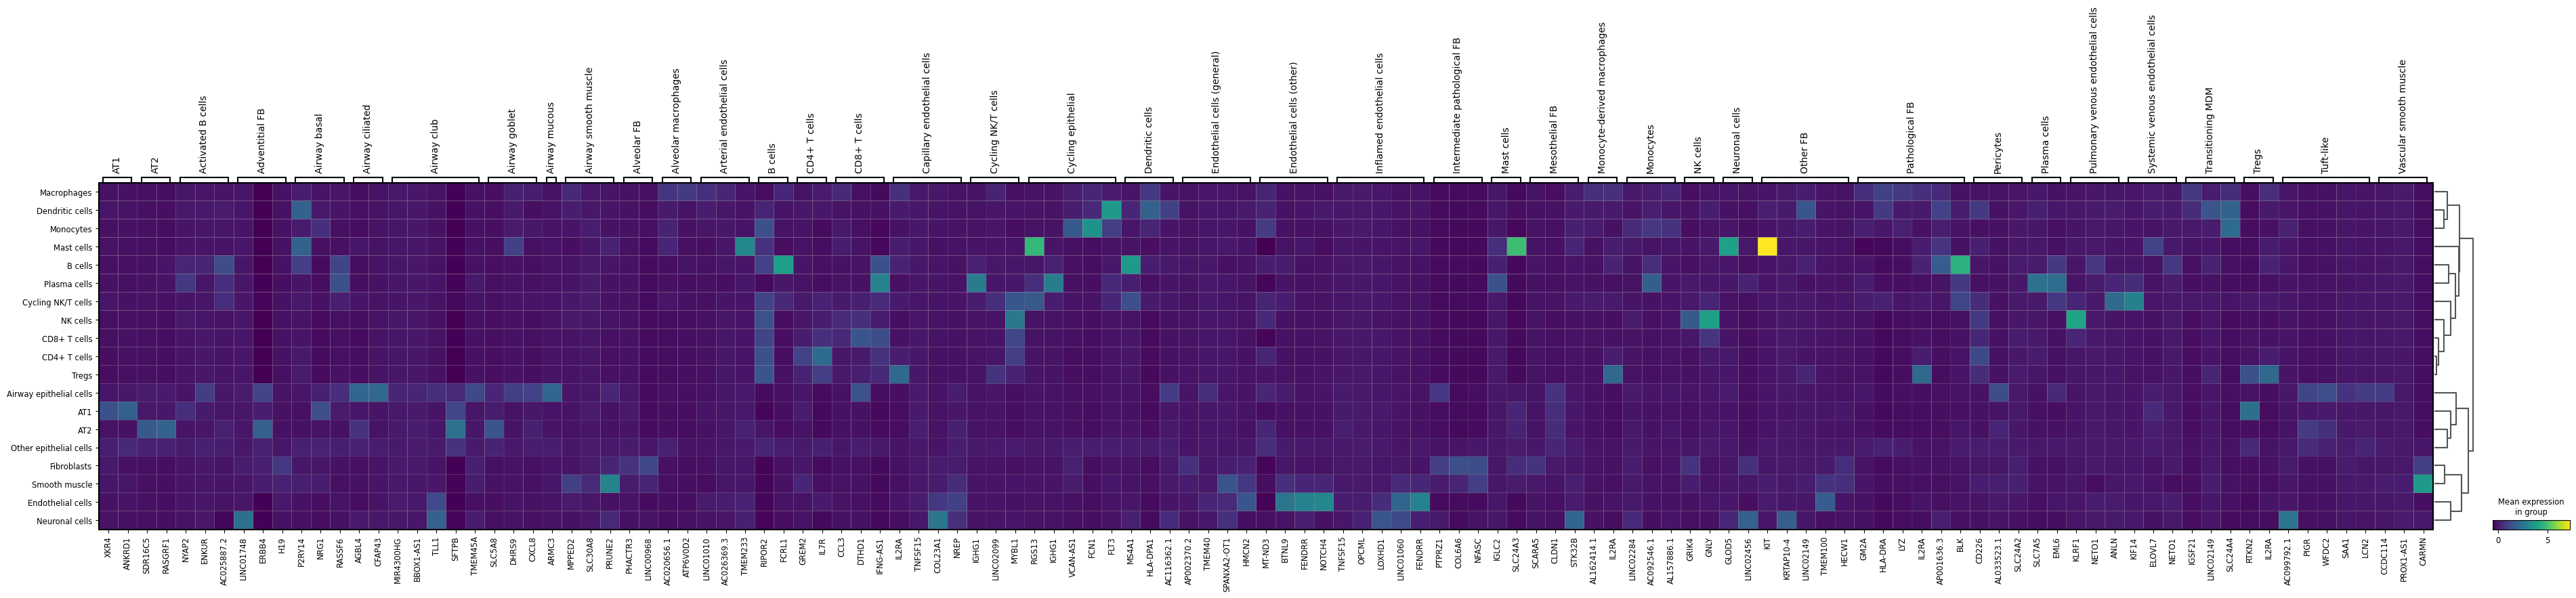

In [15]:
markers_2 = dict(zip(NSForest_results_2['clusterName'], NSForest_results_2['NSForest_markers']))
sc.pl.matrixplot(adata, markers_2, groupby='cell_type', dendrogram = True)